In [201]:
import pandas as pd
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_rows', None) 
pd.set_option('display.float_format', '{:.2f}'.format)

# 
import numpy, scipy, statsmodels, matplotlib
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats






In [203]:
df = pd.read_csv("case_study_preprocessing_touchpoint_id.csv")
df = df[df['COUNTRY'] == 'IT']

df.head()


,TOUCHPOINT_ID,REASON,DETAILED_REASON,REASON_GROUP,COUNTRY,CHANNEL,STATUS,MERCHANT_ID,MCC_GROUP,TOTAL_HANDLING_TIME_SECONDS,RESPONSE_TIME_SECONDS,QUEUE_WAITING_TIME_SECONDS,AGENT_ID,AGENT_COMPANY,CREATED_AT,ENDED_AT,ISSUE_ID,MIN_CREATED_AT,MAX_ENDED_AT,FINAL_STATUS,TOTAL_TOUCHPOINTS,TOTAL_RESOLUTION_TIME_SECONDS,TOTAL_RESOLUTION_TIME_MINUTES,TOTAL_RESOLUTION_TIME_DAYS,FINAL_CHANNEL,PRIORITY
1,-202575608778639817,Outage,Outage,Outage,IT,call,Resolved,-9223313154224916571,Retail Outlet Services,250.00,42.00,42.00,3109154870074365133,BPO1,2022-03-01 17:21:24+00:00,2022-03-01 17:26:16+00:00,2,2022-03-01 17:21:24+00:00,2022-03-01 17:26:16+00:00,Resolved,1,292.00,4.87,0.00,call,1
4,4894649142308777422,Pre SignUp - SignUp,No activation code,Signup,IT,call,Resolved,-9223210546642890192,Miscellaneous Stores,684.00,10.00,10.00,-2139152697461735578,BPO1,2022-03-29 19:42:56+00:00,2022-03-29 19:54:30+00:00,5,2022-03-29 19:42:56+00:00,2022-03-29 19:54:30+00:00,Resolved,1,694.00,11.57,0.01,call,3
5,4500106039021375161,SUP - Profile,SUP: Change other details,Changing account details,IT,email,Resolved,-9223183757003031954,Miscellaneous Stores,0.00,31158.00,0.00,8817975702393619368,SUMUP,2022-05-03 09:21:30+00:00,2022-05-03 18:00:48+00:00,6,2022-05-03 09:21:30+00:00,2022-05-03 18:00:48+00:00,Resolved,1,31158.00,519.30,0.36,email,3
6,-8945856772107419303,SumUp Card,CRD: MFA issue,Other technical issues,IT,call,Resolved,-9223059260326693727,Professional Services and Membership Organizations,723.00,10.00,10.00,-3343806823028458668,BPO2,2022-10-19 14:53:16+00:00,2022-10-19 15:05:29+00:00,7,2022-10-19 14:53:16+00:00,2022-10-19 15:05:29+00:00,Resolved,1,733.00,12.22,0.01,call,2
8,-7102625943245387551,SUP - Onboarding,SUP: Onboarding completed,Merchant verification,IT,email,Resolved,-9222806096208500172,Miscellaneous Stores,0.00,323299.00,0.00,8817975702393619368,SUMUP,2022-07-28 15:37:42+00:00,2022-08-01 09:26:01+00:00,9,2022-07-28 15:37:42+00:00,2022-08-01 09:26:01+00:00,Resolved,1,323299.00,5388.32,3.74,email,2


In [204]:
# Step 1: Convert the CREATED_AT column to datetime and extract the month
df['CREATED_AT'] = pd.to_datetime(df['CREATED_AT'])
df['month'] = df['CREATED_AT'].dt.month

# Step 2: Group by AGENT_COMPANY, CHANNEL, and month, and calculate total volumes
grouped_df = df.groupby(['AGENT_COMPANY', 'CHANNEL', 'month']).size().reset_index(name='total_volumes')

# Step 3: Adjust total volumes for 'chat' channel (divide by 3)
grouped_df.loc[grouped_df['CHANNEL'] == 'chat', 'total_volumes'] /= 3

# Step 4: Calculate the total volumes grouped by AGENT_COMPANY and month
grouped_df['total_volume_by_company_month'] = grouped_df.groupby(['AGENT_COMPANY', 'month'])['total_volumes'].transform('sum')

# Display the resulting dataframe
grouped_df.head()


,AGENT_COMPANY,CHANNEL,month,total_volumes,total_volume_by_company_month
0,BPO1,call,1,2657.00,5434.33
1,BPO1,call,2,2833.00,5277.00
2,BPO1,call,3,3713.00,6500.67
3,BPO1,call,4,3107.00,5553.67
4,BPO1,call,5,3965.00,6931.67


In [205]:
df.dtypes

TOUCHPOINT_ID                                  int64
REASON                                        object
DETAILED_REASON                               object
REASON_GROUP                                  object
COUNTRY                                       object
CHANNEL                                       object
STATUS                                        object
MERCHANT_ID                                    int64
MCC_GROUP                                     object
TOTAL_HANDLING_TIME_SECONDS                  float64
RESPONSE_TIME_SECONDS                        float64
QUEUE_WAITING_TIME_SECONDS                   float64
AGENT_ID                                       int64
AGENT_COMPANY                                 object
CREATED_AT                       datetime64[ns, UTC]
ENDED_AT                                      object
ISSUE_ID                                       int64
MIN_CREATED_AT                                object
MAX_ENDED_AT                                  

In [206]:

df['CREATED_AT'] = pd.to_datetime(df['CREATED_AT'], errors='coerce')

# Check if any values are NaT after conversion
if df['CREATED_AT'].isnull().any():
    print("There are NaT values in 'CREATED_AT' after conversion. Please check the data.")

# Step 2: Create 'CREATED_AT_WEEK' column representing the week of the year
df['CREATED_AT_WEEK'] = df['CREATED_AT'].dt.isocalendar().week

# Check for NaN values in 'CREATED_AT_WEEK'
if df['CREATED_AT_WEEK'].isnull().any():
    print("There are NaN values in 'CREATED_AT_WEEK'. Please check the data.")

# Step 3: Count distinct 'AGENT_ID' per week and by 'AGENT_COMPANY'
weekly_agent_count = df.groupby(['CREATED_AT_WEEK', 'AGENT_COMPANY'])['AGENT_ID'].nunique().reset_index()

# Rename the columns for clarity
weekly_agent_count.rename(columns={'AGENT_ID': 'DISTINCT_AGENT_COUNT'}, inplace=True)
weekly_agent_count['TOTAL_HOURS'] = weekly_agent_count['DISTINCT_AGENT_COUNT'] * 40



weekly_agent_count['MONTH'] = ((weekly_agent_count['CREATED_AT_WEEK'] - 1) // 4) + 1

# Step 2: Aggregate to monthly level
monthly_agg = weekly_agent_count.groupby(['MONTH', 'AGENT_COMPANY'], as_index=False).agg({
    'DISTINCT_AGENT_COUNT': 'sum',
    'TOTAL_HOURS': 'sum'
})

# Step 3: Rename columns for clarity
monthly_agg.rename(columns={'MONTH': 'CREATED_AT_MONTH'}, inplace=True)

# Step 1: Adjust the total hours for SUMUP (twice as expensive)
monthly_agg['ADJUSTED_TOTAL_HOURS'] = monthly_agg['TOTAL_HOURS']
monthly_agg.loc[monthly_agg['AGENT_COMPANY'] == 'SUMUP', 'ADJUSTED_TOTAL_HOURS'] *= 0.5

# Step 2: Calculate total adjusted hours per month (not overall)
total_adjusted_hours_per_month = monthly_agg.groupby('CREATED_AT_MONTH')['ADJUSTED_TOTAL_HOURS'].sum().reset_index()

# Step 3: Merge adjusted hours into the monthly_agg dataframe
monthly_agg = pd.merge(monthly_agg, total_adjusted_hours_per_month, on='CREATED_AT_MONTH', suffixes=('', '_PER_MONTH'))

# Step 4: Calculate the cost per adjusted hour for each month
monthly_agg['COST_PER_ADJUSTED_HOUR'] = 500000 / monthly_agg['ADJUSTED_TOTAL_HOURS_PER_MONTH']

# Step 5: Allocate the cost to each agent company based on adjusted total hours
monthly_agg['ALLOCATED_COST_PER_COMPANY'] = monthly_agg['ADJUSTED_TOTAL_HOURS'] * monthly_agg['COST_PER_ADJUSTED_HOUR']

# Step 6: Merge grouped_df with monthly_agg to bring in the company-level cost
merged_df = pd.merge(grouped_df, monthly_agg[['AGENT_COMPANY', 'CREATED_AT_MONTH', 'ALLOCATED_COST_PER_COMPANY']], 
                     left_on=['AGENT_COMPANY', 'month'], 
                     right_on=['AGENT_COMPANY', 'CREATED_AT_MONTH'], 
                     how='left')

# Step 7: Calculate the cost split across channels based on volume proportions
merged_df['CHANNEL_COST_PROPORTION'] = merged_df['total_volumes'] / merged_df['total_volume_by_company_month']

# Step 8: Calculate the allocated cost per channel
merged_df['ALLOCATED_COST_PER_CHANNEL'] = merged_df['ALLOCATED_COST_PER_COMPANY'] * merged_df['CHANNEL_COST_PROPORTION']

# Step 9: Sort by month to order the results
final_result_df = merged_df[['AGENT_COMPANY', 'CHANNEL', 'month', 'ALLOCATED_COST_PER_CHANNEL']]
final_result_df = final_result_df.sort_values(by='month').reset_index(drop=True)
final_result_df.head()



,AGENT_COMPANY,CHANNEL,month,ALLOCATED_COST_PER_CHANNEL
0,BPO1,call,1,185470.24
1,BPO1,email,1,102123.81
2,BPO2,chat,1,6462.46
3,BPO2,email,1,14651.20
4,BPO1,chat,1,91746.23


In [207]:
total_cost_month_3 = final_result_df[final_result_df['month'] == 3]['ALLOCATED_COST_PER_CHANNEL'].sum()

total_cost_month_3

499999.99999999994

In [208]:

df['CREATED_AT'] = pd.to_datetime(df['CREATED_AT'], errors='coerce')
df['CREATED_AT_WEEK'] = df['CREATED_AT'].dt.isocalendar().week

# Count distinct 'AGENT_ID' per week and by 'AGENT_COMPANY'
weekly_agent_count = (df.groupby(['CREATED_AT_WEEK', 'AGENT_COMPANY'])['AGENT_ID']
                      .nunique()
                      .reset_index(name='DISTINCT_AGENT_COUNT'))

# Calculate TOTAL_HOURS directly
weekly_agent_count['TOTAL_HOURS'] = weekly_agent_count['DISTINCT_AGENT_COUNT'] * 40

# Calculate the MONTH from CREATED_AT_WEEK
weekly_agent_count['MONTH'] = ((weekly_agent_count['CREATED_AT_WEEK'] - 1) // 4) + 1



# Step 3: Aggregate to monthly level
monthly_agg = (weekly_agent_count.groupby(['MONTH', 'AGENT_COMPANY'], as_index=False)
                .agg({'DISTINCT_AGENT_COUNT': 'sum', 'TOTAL_HOURS': 'sum'}))

monthly_agg.rename(columns={'MONTH': 'CREATED_AT_MONTH'}, inplace=True)

# Adjust total hours for SUMUP (1.5 as expensive)
monthly_agg['ADJUSTED_TOTAL_HOURS'] = monthly_agg['TOTAL_HOURS'].where(monthly_agg['AGENT_COMPANY'] == 'SUMUP',
                                                                         monthly_agg['TOTAL_HOURS'] * 0.5)

# Calculate total adjusted hours per month and merge back to monthly_agg
total_adjusted_hours_per_month = monthly_agg.groupby('CREATED_AT_MONTH')['ADJUSTED_TOTAL_HOURS'].sum().reset_index()
monthly_agg = monthly_agg.merge(total_adjusted_hours_per_month, on='CREATED_AT_MONTH', suffixes=('', '_PER_MONTH'))

# Calculate cost per adjusted hour for each month
monthly_agg['COST_PER_ADJUSTED_HOUR'] = 500000 / monthly_agg['ADJUSTED_TOTAL_HOURS_PER_MONTH']

# Allocate cost to each agent company based on adjusted total hours
monthly_agg['ALLOCATED_COST_PER_COMPANY'] = monthly_agg['ADJUSTED_TOTAL_HOURS'] * monthly_agg['COST_PER_ADJUSTED_HOUR']

# Merge with grouped_df to bring in the company-level cost
merged_df = grouped_df.merge(monthly_agg[['AGENT_COMPANY', 'CREATED_AT_MONTH', 'ALLOCATED_COST_PER_COMPANY']], 
                              left_on=['AGENT_COMPANY', 'month'], 
                              right_on=['AGENT_COMPANY', 'CREATED_AT_MONTH'], 
                              how='left')

# Calculate the cost split across channels based on volume proportions
merged_df['CHANNEL_COST_PROPORTION'] = merged_df['total_volumes'] / merged_df['total_volume_by_company_month']


# Calculate the allocated cost per channel
merged_df['ALLOCATED_COST_PER_CHANNEL'] = merged_df['ALLOCATED_COST_PER_COMPANY'] * merged_df['CHANNEL_COST_PROPORTION']

# Step: Aggregate to sum costs per channel across all agent companies
final_result_df = (merged_df.groupby(['CHANNEL', 'month'], as_index=False)
                   .agg({'ALLOCATED_COST_PER_CHANNEL': 'sum'}))

# Sort the results by month
final_result_df = final_result_df.sort_values(by='month').reset_index(drop=True)

# Display the final result
final_result_df.head()


,CHANNEL,month,ALLOCATED_COST_PER_CHANNEL
0,call,1,227561.19
1,email,1,187882.45
2,chat,1,84556.36
3,call,2,242299.39
4,email,2,179045.89


In [209]:
total_cost_month_3 = final_result_df[final_result_df['month'] == 3]['ALLOCATED_COST_PER_CHANNEL'].sum()

total_cost_month_3

499999.9999999999

In [210]:
total_adjusted_hours_per_month.head()

,CREATED_AT_MONTH,ADJUSTED_TOTAL_HOURS
0,1,13380
1,2,14760
2,3,11120
3,4,11720
4,5,12800


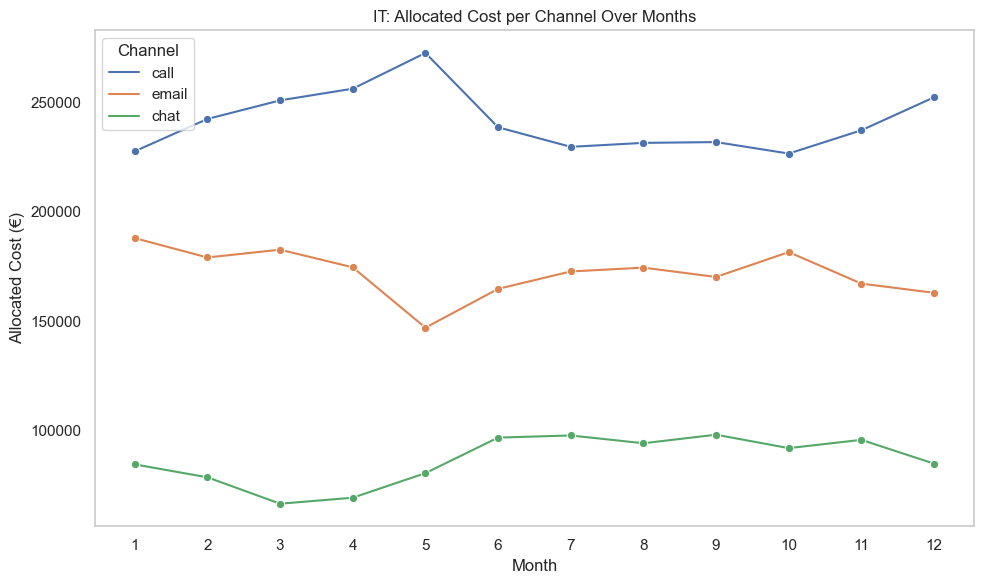

In [211]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_result_df, x='month', y='ALLOCATED_COST_PER_CHANNEL', hue='CHANNEL', marker='o')

# Add titles and labels
plt.title('IT: Allocated Cost per Channel Over Months')
plt.xlabel('Month')
plt.ylabel('Allocated Cost (€)')
plt.xticks(final_result_df['month'].unique())  # Set x-ticks to be the unique months
plt.legend(title='Channel')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

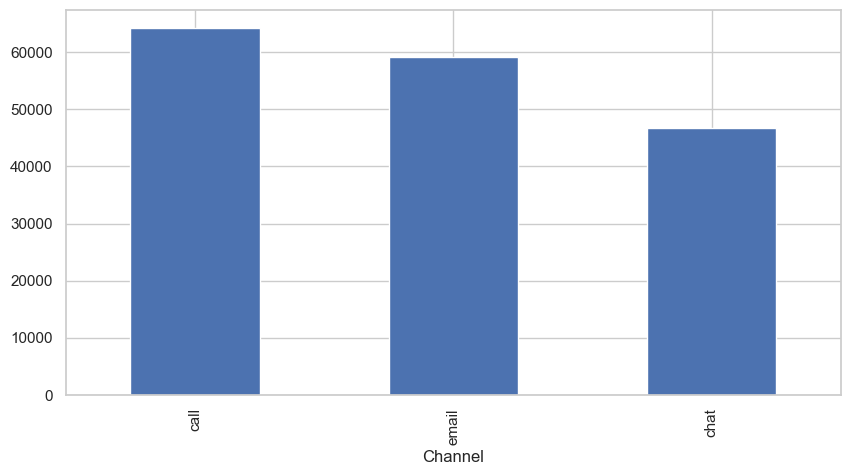

In [212]:
df.CHANNEL.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
matplotlib.pyplot.xlabel('Channel');

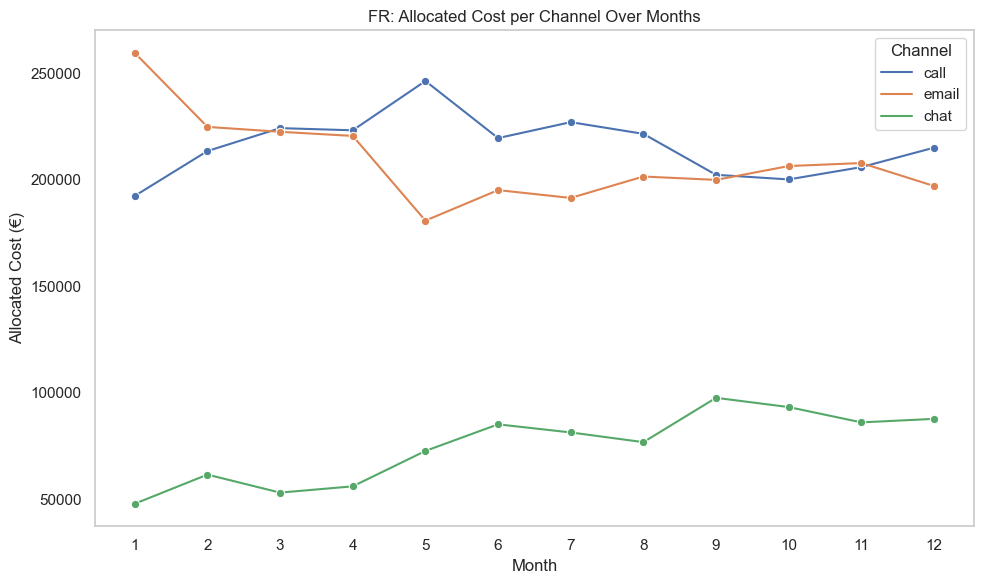

In [200]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_result_df, x='month', y='ALLOCATED_COST_PER_CHANNEL', hue='CHANNEL', marker='o')

# Add titles and labels
plt.title('FR: Allocated Cost per Channel Over Months')
plt.xlabel('Month')
plt.ylabel('Allocated Cost (€)')
plt.xticks(final_result_df['month'].unique())  # Set x-ticks to be the unique months
plt.legend(title='Channel')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

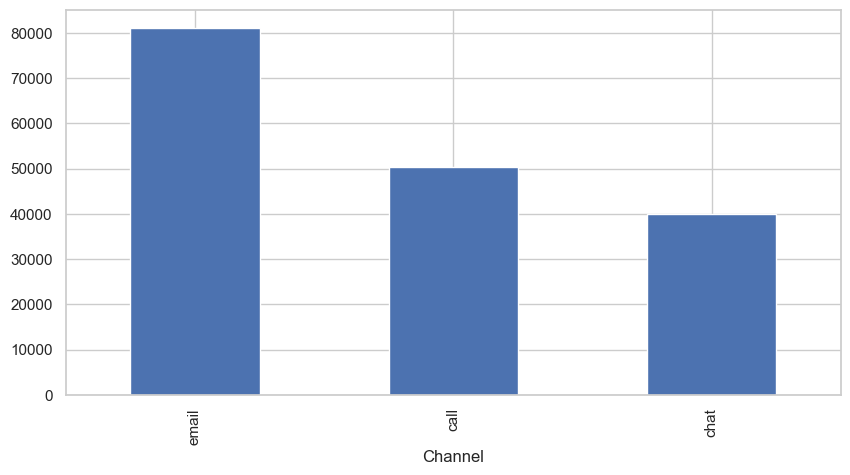

In [197]:
df.CHANNEL.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
matplotlib.pyplot.xlabel('Channel');

In [198]:
8/14


0.5714285714285714

In [199]:
75/250


0.3